In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

## Lasso & Ridge

In [3]:
ploan = pd.read_csv('./data/Personal Loan.csv')
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


```
Experience 경력
Income 수입
Family 가족 단위
CCAvg 월 카드 사용량
Education 교육수준 (1:undergrad, 2:Graduate, 3:Advance)
Mortgage 가계대출
Securities account 유가증권계좌 유무
CD account 양도예금증서계좌 유무
Online 온라인계좌 유무
CreditCard 신용카드 유무
```

In [49]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [50]:
ploan_processed = ploan.dropna().drop(['ID', 'ZIP Code'], axis=1)

feature_columns = list(ploan_processed.columns.difference(['Personal Loan']))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan']

In [51]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.3, train_size=0.7, random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 11) (750, 11) (1750,) (750,)


In [74]:
ll = Lasso(alpha=0.01)
ll.fit(train_x, train_y)

Lasso(alpha=0.01)

In [75]:
# 회귀계수
ll.coef_

array([ 0.00000000e+00,  2.04783983e-03,  1.14390390e-01, -0.00000000e+00,
        6.58342418e-02,  4.76625359e-04,  3.13396711e-02,  3.55393865e-03,
        1.31719530e-05,  0.00000000e+00, -0.00000000e+00])

In [76]:
def cut_off(y, threshold):
    Y = y.copy()
    Y[Y > threshold] = 1
    Y[Y < threshold] = 0
    return Y.astype(int)

In [77]:
def acc(cfmt):
    acc = (cfmat[0,0] + cfmat[1,1]) / (cfmat[0,0] + cfmat[0,1] + cfmat[1,0] + cfmat[1,1])
    return acc

In [78]:
pred_y_lasso = ll.predict(test_x)
pred_Y_lasso = cut_off(pred_y_lasso, 0.5)
cfmat = confusion_matrix(test_y, pred_Y_lasso)
print(acc(cfmat))

0.936


AUC: 0.9465467667547905


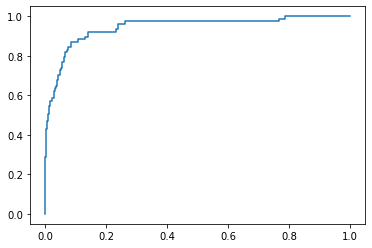

In [79]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_lasso, pos_label=1)

plt.plot(fpr, tpr)
aus = np.trapz(tpr, fpr)
print('AUC:', auc )

In [83]:
rr = Ridge(alpha=0.01)
rr.fit(train_x, train_y)

Ridge(alpha=0.01)

In [84]:
rr.coef_

array([-3.71283678e-03,  7.37570775e-03,  3.54973975e-01, -5.28579506e-02,
        7.83404224e-02,  4.12823466e-03,  3.62504712e-02,  3.27385112e-03,
        1.73105480e-06, -1.91297381e-02, -8.77388670e-02])

In [85]:
ll.coef_

array([ 0.00000000e+00,  2.04783983e-03,  1.14390390e-01, -0.00000000e+00,
        6.58342418e-02,  4.76625359e-04,  3.13396711e-02,  3.55393865e-03,
        1.31719530e-05,  0.00000000e+00, -0.00000000e+00])

In [86]:
pred_y_ridge = rr.predict(test_x) # full model
pred_Y_ridge= cut_off(pred_y_ridge,0.5)
cfmat = confusion_matrix(test_y, pred_Y_lasso)
print(acc(cfmat))

0.936


AUC: 0.9494992377607533


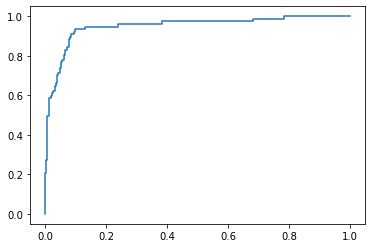

In [87]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y_ridge, pos_label=1)
# Print ROC curve
plt.plot(fpr,tpr)
# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [88]:
alpha = np.logspace(-3, 1, 5)
alpha

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [89]:
data = []
acc_table=[]
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))
    pred_y = lasso.predict(test_x) # full model
    pred_y= cut_off(pred_y,0.5)
    cfmat = confusion_matrix(test_y, pred_y)
    acc_table.append((acc(cfmat)))
    

df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso
acc_table_lasso = pd.DataFrame(acc_table, index=alpha).T

In [90]:
df_lasso

,0.001,0.010,0.100,1.000,10.000
0,-0.335006,-0.381869,-0.143698,-0.113103,0.102286
1,-0.002109,0.000000,0.000000,0.000000,-0.000000
2,0.006829,0.002048,0.000000,0.000000,0.000000
3,0.322174,0.114390,0.000000,0.000000,0.000000
4,-0.043385,-0.000000,-0.000000,-0.000000,-0.000000
5,0.076771,0.065834,0.000000,0.000000,0.000000
6,0.002534,0.000477,0.000000,0.000000,-0.000000
7,0.035728,0.031340,0.000000,0.000000,0.000000
8,0.003313,0.003554,0.003291,0.002893,0.000000
9,0.000004,0.000013,0.000016,0.000000,0.000000


In [91]:
acc_table_lasso

,0.001,0.010,0.100,1.000,10.000
0,0.932,0.936,0.894667,0.897333,0.897333


In [92]:
data = []
acc_table=[]
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))
    pred_y = ridge.predict(test_x) # full model
    pred_y= cut_off(pred_y,0.5)
    cfmat = confusion_matrix(test_y, pred_y)
    acc_table.append((acc(cfmat)))

    
df_ridge = pd.DataFrame(data, index=alpha).T
acc_table_ridge = pd.DataFrame(acc_table, index=alpha).T

In [93]:
df_ridge

,0.001,0.010,0.100,1.000,10.000
0,-0.289557,-0.289565,-0.289645,-0.290438,-0.297581
1,-0.003713,-0.003713,-0.003713,-0.003716,-0.003723
2,0.007376,0.007376,0.007376,0.007378,0.007388
3,0.355019,0.354974,0.354529,0.350141,0.311781
4,-0.052866,-0.052858,-0.052782,-0.052037,-0.045541
5,0.078340,0.078340,0.078341,0.078347,0.078316
6,0.004128,0.004128,0.004129,0.004136,0.004175
7,0.036250,0.036250,0.036254,0.036289,0.036578
8,0.003274,0.003274,0.003274,0.003278,0.003313
9,0.000002,0.000002,0.000002,0.000002,0.000004


In [94]:
acc_table_ridge

,0.001,0.010,0.100,1.000,10.000
0,0.932,0.932,0.932,0.932,0.932


### lambda값의 변화에 따른 회귀계수 축소 시각화

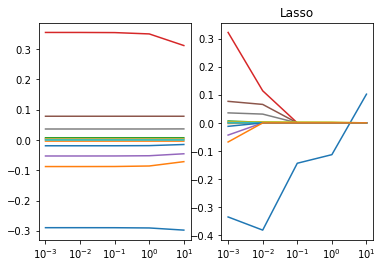

In [95]:
import matplotlib.pyplot as plt
ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha)

ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha)
plt.title("Lasso")

plt.show()